<a href="https://colab.research.google.com/github/GangadharVG518/CSDGroupProject/blob/main/Oil%20Spill%20Detection%20using%20Satellite%20Imagery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Training Images Path: /content/drive/MyDrive/Oil Spill dataset/dataset/train/images
Training Masks Path: /content/drive/MyDrive/Oil Spill dataset/dataset/train/masks
 Folders found!
Number of Images: 811
Number of Masks: 811
Using Image: /content/drive/MyDrive/Oil Spill dataset/dataset/train/images/Oil (1015).jpg
Using Mask: /content/drive/MyDrive/Oil Spill dataset/dataset/train/masks/Oil (1015).png


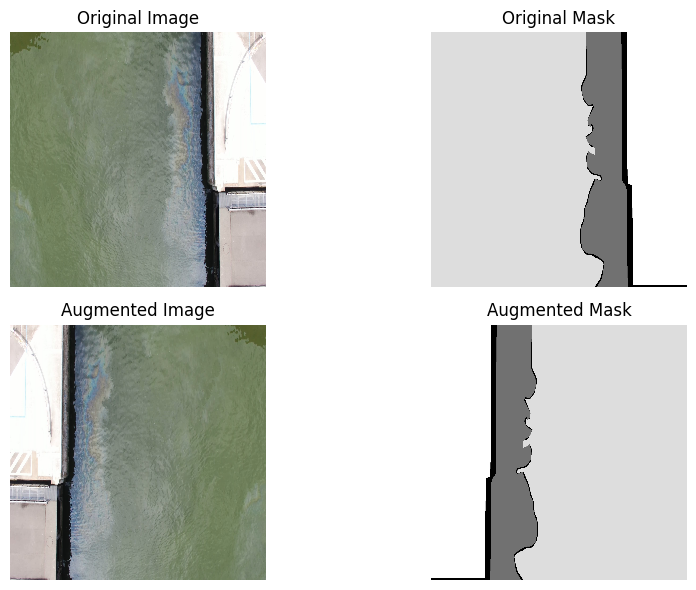

In [ ]:
# STEP 1: Mounted my colab to  Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os, cv2, glob
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

# STEP 2: Setting  base dataset path
BASE_PATH = "/content/drive/MyDrive/Oil Spill dataset/dataset"

TRAIN_IMG_DIR = os.path.join(BASE_PATH, "train/images")
TRAIN_MASK_DIR = os.path.join(BASE_PATH, "train/masks")

print("Training Images Path:", TRAIN_IMG_DIR)
print("Training Masks Path:", TRAIN_MASK_DIR)

# STEP 3: Here Checking  if folders exist or not that we wantt to train
if not os.path.exists(TRAIN_IMG_DIR):
    raise FileNotFoundError(f" Could not find {TRAIN_IMG_DIR}. Check folder name in Drive.")
if not os.path.exists(TRAIN_MASK_DIR):
    raise FileNotFoundError(f" Could not find {TRAIN_MASK_DIR}. Check folder name in Drive.")

print(" Folders found!")
print("Number of Images:", len(os.listdir(TRAIN_IMG_DIR)))
print("Number of Masks:", len(os.listdir(TRAIN_MASK_DIR)))

# STEP 4: Preprocessing functions(preprocess image then masking etc)
IMG_SIZE = (256, 256)

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    return img

def preprocess_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, IMG_SIZE)
    mask = mask / 255.0   # normalize to 0/1
    return mask

# STEP 5: Picking a sample image and its mask (handles .png/.jpg automatically)
sample_image_name = os.listdir(TRAIN_IMG_DIR)[0]   # first image
img_path = os.path.join(TRAIN_IMG_DIR, sample_image_name)

# find matching mask
mask_candidates = glob.glob(os.path.join(TRAIN_MASK_DIR, sample_image_name.split('.')[0] + ".*"))
if not mask_candidates:
    raise FileNotFoundError(f" No mask found for {sample_image_name}")
mask_path = mask_candidates[0]

print("Using Image:", img_path)
print("Using Mask:", mask_path)

# Load them
img = preprocess_image(img_path)
mask = preprocess_mask(mask_path)

# STEP 6: Augmentation (flip + rotate)  image..
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Rotate(limit=30, p=0.5)
])

augmented = augment(image=img, mask=mask)
aug_img = augmented['image']
aug_mask = augmented['mask']

# STEP 7: Visualization (Original vs Augmented)
plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(mask, cmap='gray')
plt.title("Original Mask")
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(aug_img)
plt.title("Augmented Image")
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(aug_mask, cmap='gray')
plt.title("Augmented Mask")
plt.axis('off')

plt.tight_layout()
plt.show()




#week 3-4
import tensorflow as tf
from tensorflow.keras import layers, models

# Simple U-Net like model
def build_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    # Bottleneck
    b = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p2)
    b = layers.Conv2D(64, (3,3), activation='relu', padding='same')(b)

    # Decoder
    u1 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(b)
    u1 = layers.concatenate([u1, c2])
    c3 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c3)

    u2 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c3)
    u2 = layers.concatenate([u2, c1])
    c4 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c4)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model





In [ ]:

import time, os, glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K

# Dice and IoU definitions (numpy for evaluation, Keras for loss) ---
def dice_coef_np(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.reshape(-1)
    y_pred_f = y_pred.reshape(-1)
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_np(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.reshape(-1)
    y_pred_f = y_pred.reshape(-1)
    inter = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)

# Keras dice loss
def dice_loss_keras(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Combined loss: BinaryCrossentropy + Dicee
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dl = dice_loss_keras(y_true, y_pred)
    return bce + dl

# IoU metric for training display (keras)
def iou_keras(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    inter = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)

#  Model builder
def build_unet(input_shape=(256,256,3)):
    inputs = tf.keras.layers.Input(shape=input_shape)
    # Encoder
    c1 = tf.keras.layers.Conv2D(16,3,activation='relu',padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(16,3,activation='relu',padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D()(c1)

    c2 = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D()(c2)

    b = tf.keras.layers.Conv2D(64,3,activation='relu',padding='same')(p2)
    b = tf.keras.layers.Conv2D(64,3,activation='relu',padding='same')(b)

    u1 = tf.keras.layers.Conv2DTranspose(32,2,strides=2,padding='same')(b)
    u1 = tf.keras.layers.concatenate([u1, c2])
    c3 = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(u1)
    c3 = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(c3)

    u2 = tf.keras.layers.Conv2DTranspose(16,2,strides=2,padding='same')(c3)
    u2 = tf.keras.layers.concatenate([u2, c1])
    c4 = tf.keras.layers.Conv2D(16,3,activation='relu',padding='same')(u2)
    c4 = tf.keras.layers.Conv2D(16,3,activation='relu',padding='same')(c4)

    outputs = tf.keras.layers.Conv2D(1,1,activation='sigmoid')(c4)
    model = tf.keras.models.Model(inputs, outputs)
    return model


In [ ]:

import os
from sklearn.model_selection import train_test_split

IMG_SIZE=(256,256)
def preprocess_image_simple(p):
    img = tf.keras.preprocessing.image.load_img(p, target_size=IMG_SIZE)
    arr = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    return arr

def preprocess_mask_simple(p):
    m = tf.keras.preprocessing.image.load_img(p, target_size=IMG_SIZE, color_mode='grayscale')
    ma = tf.keras.preprocessing.image.img_to_array(m)/255.0
    ma = (ma > 0.5).astype(np.float32)
    return ma

# Paths
TRAIN_IMG_DIR = "/content/drive/MyDrive/Oil Spill dataset/dataset/train/images"
TRAIN_MASK_DIR = "/content/drive/MyDrive/Oil Spill dataset/dataset/train/masks"

img_files = sorted([f for f in os.listdir(TRAIN_IMG_DIR) if f.lower().endswith(('.png','.jpg','.tif','.jpeg'))])
X_all, y_all = [], []
for fn in img_files:
    img_p = os.path.join(TRAIN_IMG_DIR, fn)

    base = os.path.splitext(fn)[0]
    mask_candidates = [g for g in os.listdir(TRAIN_MASK_DIR) if os.path.splitext(g)[0]==base]
    if len(mask_candidates)==0:
        continue
    mask_p = os.path.join(TRAIN_MASK_DIR, mask_candidates[0])
    X_all.append(preprocess_image_simple(img_p))
    y_all.append(preprocess_mask_simple(mask_p))

X = np.array(X_all, dtype=np.float32)
y = np.array(y_all, dtype=np.float32)
y = y.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)

print("Loaded shapes:", X.shape, y.shape)
# Split:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train:", X_train.shape, y_train.shape, "Val:", X_val.shape, y_val.shape)



Loaded shapes: (811, 256, 256, 3) (811, 256, 256, 1)
Train: (648, 256, 256, 3) (648, 256, 256, 1) Val: (163, 256, 256, 3) (163, 256, 256, 1)


In [ ]:
import os, numpy as np, tensorflow as tf
from tqdm import tqdm

IMG_SIZE = (256, 256)

def preprocess_image_simple(p):
    img = tf.keras.preprocessing.image.load_img(p, target_size=IMG_SIZE)
    arr = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    return arr

def preprocess_mask_simple(p):
    m = tf.keras.preprocessing.image.load_img(p, target_size=IMG_SIZE, color_mode='grayscale')
    ma = tf.keras.preprocessing.image.img_to_array(m) / 255.0
    ma = (ma > 0.5).astype(np.float32)
    return ma

#   dataset paths
TRAIN_IMG_DIR = "/content/drive/MyDrive/Oil Spill dataset/dataset/train/images"
TRAIN_MASK_DIR = "/content/drive/MyDrive/Oil Spill dataset/dataset/train/masks"

# Checking  folders and paths
if not os.path.exists(TRAIN_IMG_DIR):
    raise FileNotFoundError(f" Could not find {TRAIN_IMG_DIR}")
if not os.path.exists(TRAIN_MASK_DIR):
    raise FileNotFoundError(f"Could not find {TRAIN_MASK_DIR}")

img_files = sorted([f for f in os.listdir(TRAIN_IMG_DIR) if f.lower().endswith(('.png','.jpg','.tif','.jpeg'))])

X_list, y_list = [], []

#  Here i am loading  only first 50 images for testing
for fn in tqdm(img_files[:50], desc="Loading images"):
    img_path = os.path.join(TRAIN_IMG_DIR, fn)
    mask_name = fn.split('.')[0] + ".png"  # adjust if mask is .jpg
    mask_path = os.path.join(TRAIN_MASK_DIR, mask_name)
    if os.path.exists(mask_path):
        X_list.append(preprocess_image_simple(img_path))
        y_list.append(preprocess_mask_simple(mask_path))

X = np.array(X_list, dtype=np.float32)
y = np.array(y_list, dtype=np.float32).reshape(-1, 256, 256, 1)

print(" Dataset Loaded")
print("X shape:", X.shape, "y shape:", y.shape)


Loading images: 100%|██████████| 50/50 [00:10<00:00,  4.56it/s]

 Dataset Loaded
X shape: (50, 256, 256, 3) y shape: (50, 256, 256, 1)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)


Train: (40, 256, 256, 3) (40, 256, 256, 1)
Val: (10, 256, 256, 3) (10, 256, 256, 1)


In [ ]:
#increasing model accuracy from here
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Better optimizer
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Recompile with optimizer
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=['accuracy', iou_keras])

# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=50,   # increase from 5/10 → 30–50
    callbacks=callbacks
)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.8382 - iou_keras: 0.7365 - loss: 0.5783 - val_accuracy: 0.7857 - val_iou_keras: 0.7210 - val_loss: 0.6679 - learning_rate: 2.5000e-05
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.8142 - iou_keras: 0.7244 - loss: 0.6175 - val_accuracy: 0.7857 - val_iou_keras: 0.7216 - val_loss: 0.6677 - learning_rate: 2.5000e-05
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.8112 - iou_keras: 0.7219 - loss: 0.6275 - val_accuracy: 0.7857 - val_iou_keras: 0.7225 - val_loss: 0.6676 - learning_rate: 2.5000e-05
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.8381 - iou_keras: 0.7388 - loss: 0.5749 - val_accuracy: 0.7857 - val_iou_keras: 0.7243 - val_loss: 0.6677 - learning_rate: 2.5000e-05
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.8084 - iou_keras: 0.7210 - loss: 0.6319 - val_accuracy: 0.7857 - val_iou_keras: 0.7255 - val_loss: 0.6678 - learning_rate: 2.5000e-05
Epoch 6/50
5/5 ━━━━━

In [ ]:
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5)
])


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
# Compile the improved U-Net
model = build_unet(input_shape=(256,256,3))

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Optimizer + Loss + Metrics
opt = Adam(learning_rate=1e-4)

model.compile(
    optimizer=opt,
    loss=bce_dice_loss,
    metrics=['accuracy', iou_keras, dice_coef]  #
)

# Callbacks for training improvement
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]


NameError: name 'dice_coef' is not defined

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/oilspill_model.h5",
                   custom_objects={'bce_dice_loss': bce_dice_loss,
                                   'iou_keras': iou_keras,
                                   'dice_coef': dice_coef})


NameError: name 'dice_coef' is not defined

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.1813 - dice_coef: 0.6106 - iou_keras: 0.4423 - loss: 1.0970 - val_accuracy: 0.5066 - val_dice_coef: 0.6148 - val_iou_keras: 0.4453 - val_loss: 1.0834 - learning_rate: 1.0000e-04
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.6834 - dice_coef: 0.6248 - iou_keras: 0.4565 - loss: 1.0627 - val_accuracy: 0.7793 - val_dice_coef: 0.6254 - val_iou_keras: 0.4565 - val_loss: 1.0566 - learning_rate: 1.0000e-04
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - accuracy: 0.8129 - dice_coef: 0.6306 - iou_keras: 0.4630 - loss: 1.0397 - val_accuracy: 0.7802 - val_dice_coef: 0.6363 - val_iou_keras: 0.4682 - val_loss: 1.0295 - learning_rate: 1.0000e-04
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.8167 - dice_coef: 0.6419 - iou_keras: 0.4755 - loss: 1.0099 - val_accuracy: 0.7822 - val_dice_coef: 0.6484 - val_iou_keras: 0.4814 - val_loss: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 

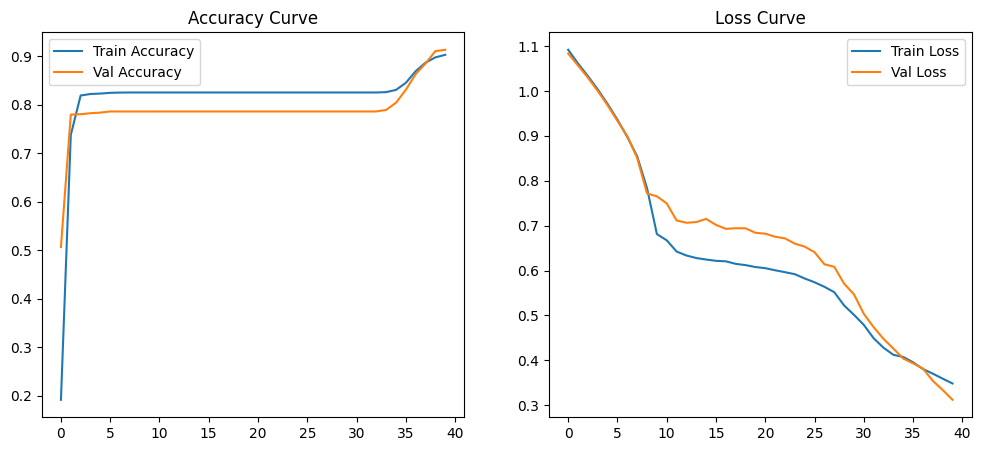

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy Curve")

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")

plt.show()


In [ ]:
results = model.evaluate(X_val, y_val, verbose=1)
print("Validation Results:")
print("Loss:", results[0])
print("Accuracy:", results[1])
print("IoU:", results[2])
print("Dice Coefficient:", results[3])


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9129 - dice_coef: 0.9158 - iou_keras: 0.8503 - loss: 0.3121
Validation Results:
Loss: 0.3120890259742737
Accuracy: 0.9128677248954773
IoU: 0.8502724170684814
Dice Coefficient: 0.915817141532898


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


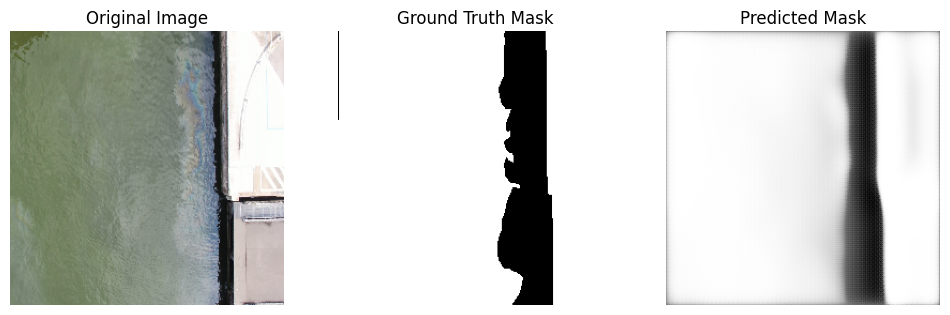

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


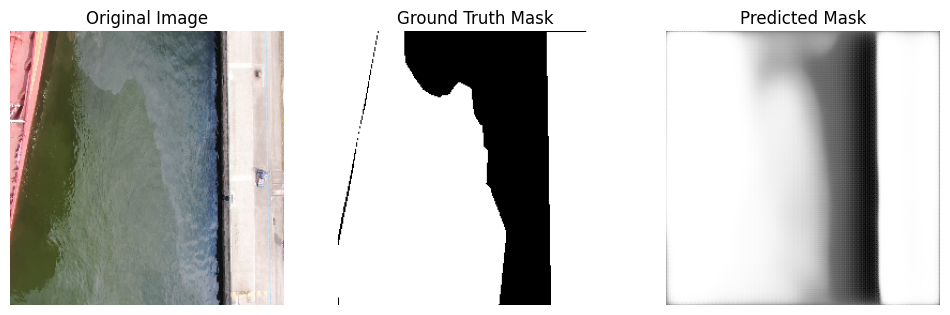

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


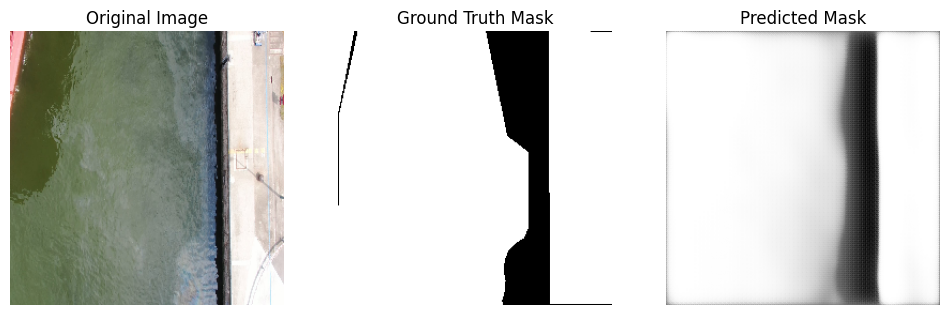

In [ ]:
import numpy as np

n_show = 3  # show 3 predictions
for i in range(n_show):
    plt.figure(figsize=(12,4))

    # Original image
    plt.subplot(1,3,1)
    plt.imshow(X_val[i])
    plt.title("Original Image")
    plt.axis('off')

    # Ground Truth
    plt.subplot(1,3,2)
    plt.imshow(y_val[i].squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Prediction
    pred_mask = model.predict(X_val[i:i+1])[0]
    plt.subplot(1,3,3)
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


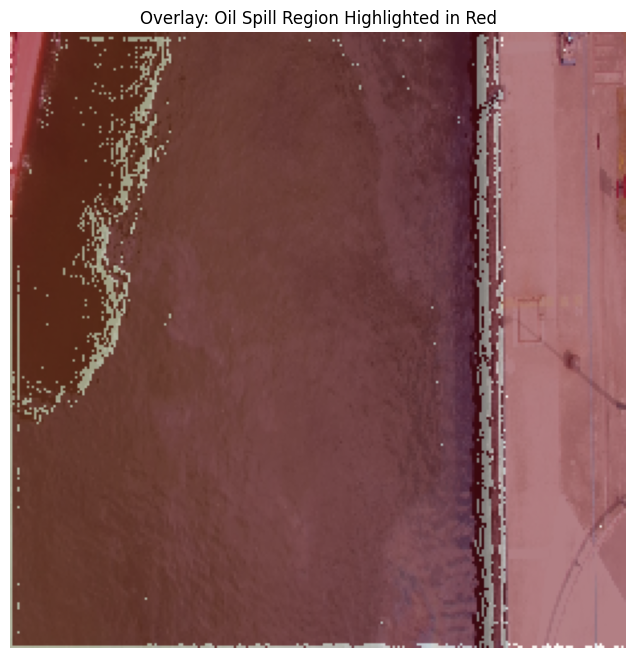

In [ ]:
i = 2
image = X_val[i]
pred_mask = model.predict(X_val[i:i+1])[0]
pred_mask = (pred_mask > 0.5).astype(np.uint8)

plt.figure(figsize=(8,8))
plt.imshow(image)
plt.imshow(pred_mask.squeeze(), cmap='Reds', alpha=0.5)
plt.title("Overlay: Oil Spill Region Highlighted in Red")
plt.axis('off')
plt.show()
